# Problem Statement
Predict if the client will subscribe to a term deposit based on the analysis of the marketing campaigns the bank performed.

The data consists of records of roughly 41000 clients and 21 features. There are 20 predictors and 1 target that describes whether the client will subscribe or not.




###  Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Loading Data Modelling Libraries

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier 
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)

## Import Dataset



In [3]:
# Load the dataframe
dataframe = pd.read_csv('data-20200611T131830Z-001/data/train.csv')
pd.set_option('display.max_columns',None)


print('Shape of the data is: ',dataframe.shape)
dataframe.head()



Shape of the data is:  (32950, 22)


,Id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,25611,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
1,26010,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,-0.1,93.200,-42.0,4.120,5195.8,no
2,40194,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,-1.7,94.215,-40.3,0.870,4991.6,yes
3,297,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,36344,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2,no


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              32950 non-null  int64  
 1   age             32950 non-null  int64  
 2   job             32950 non-null  object 
 3   marital         32950 non-null  object 
 4   education       32950 non-null  object 
 5   default         32950 non-null  object 
 6   housing         32950 non-null  object 
 7   loan            32950 non-null  object 
 8   contact         32950 non-null  object 
 9   month           32950 non-null  object 
 10  day_of_week     32950 non-null  object 
 11  duration        32950 non-null  int64  
 12  campaign        32950 non-null  int64  
 13  pdays           32950 non-null  int64  
 14  previous        32950 non-null  int64  
 15  poutcome        32950 non-null  object 
 16  emp.var.rate    32950 non-null  float64
 17  cons.price.idx  32950 non-null 

from above information we can see that there is no missing values ,and also get to know about catogorical and numerical features.

In [5]:
##drop the column which are not required for our model
# Remove the Id column from the dataset
dataframe.drop('Id',axis=1,inplace=True)

### Check for Class Imbalance
The code below that takes the target variable and outputs the distribution of classes in the target.

In [6]:
# we are finding the percentage of each class in the feature 'y'
class_values = (dataframe['y'].value_counts()/dataframe['y'].value_counts().sum())*100
print(class_values)

no     88.734446
yes    11.265554
Name: y, dtype: float64



### Observations : 
- The class distribution in the target is ~89:11. This is a clear indication of imbalance.


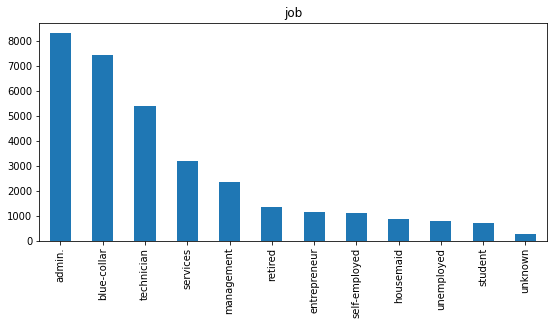

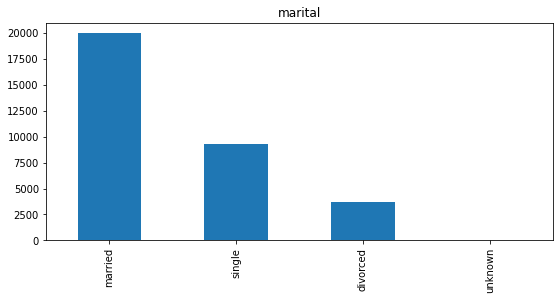

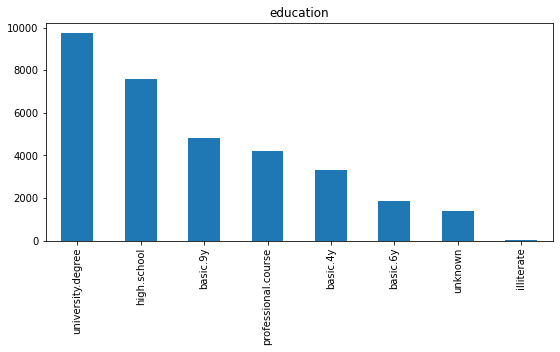

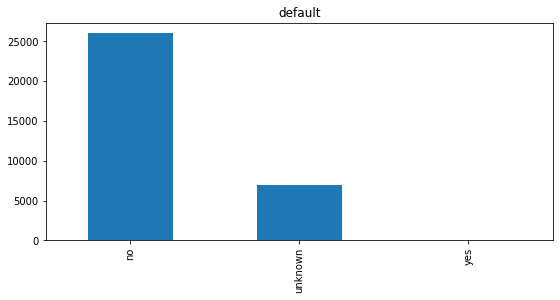

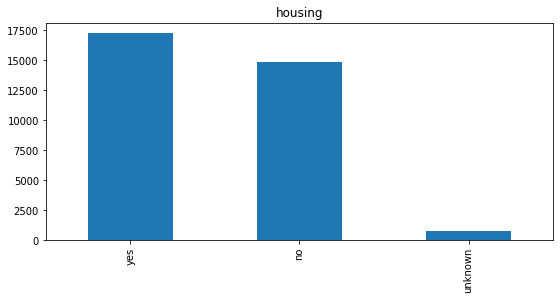

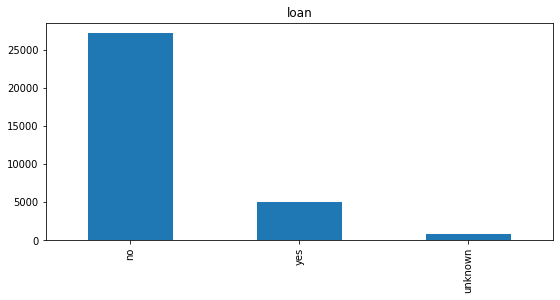

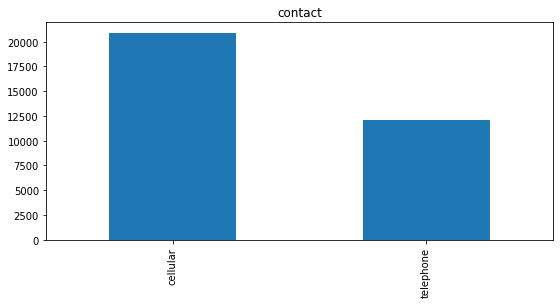

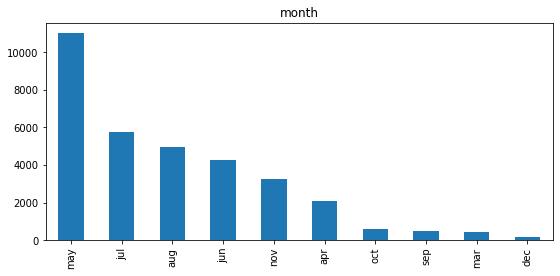

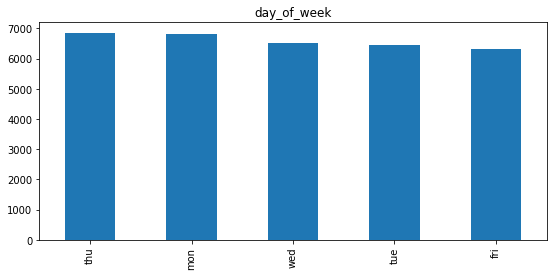

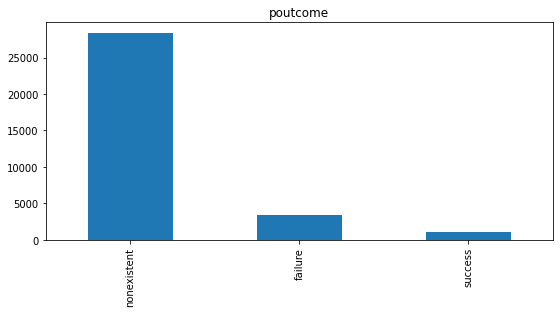

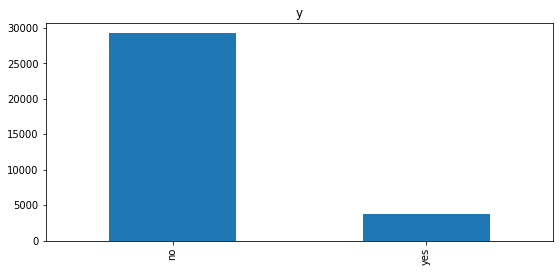

In [7]:
# Selecting the categorical columns
categorical_col = dataframe.select_dtypes(include=['object']).columns

# Plotting a bar chart for each of the cateorical variable
for column in categorical_col:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    dataframe[column].value_counts().plot(kind='bar')
    plt.title(column)

### Observations :

From the above visuals, we can make the following observations: 
- The top three professions that our customers belong to are - administration, blue-collar jobs and technicians.
- A huge number of the customers are married.
- Majority of the customers do not have a credit in default
- Many of our past customers have applied for a housing loan but very few have applied for personal loans.
- Cell-phones seem to be the most favoured method of reaching out to customers.
- Many customers have been contacted in the month of **May**.
- The plot for the target variable shows heavy imbalance in the target variable. 
- The missing values in some columns have been represented as `unknown`. `unknown` represents missing data. In the next task, we will treat these values.  

In [8]:
# Impute mising values of categorical data with mode
for column in categorical_col:
    mode = dataframe[column].mode()[0]
    dataframe[column] = dataframe[column].replace('unknown',mode)


### Univariate analysis of Continuous columns
Just like for categorical columns, by performing a univariate analysis on the continuous columns, we can get a sense of the distrbution of values in every column and of the outliers in the data. 


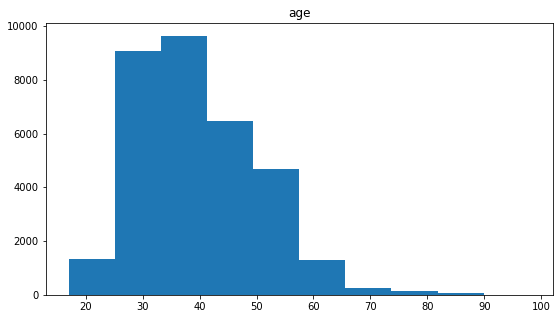

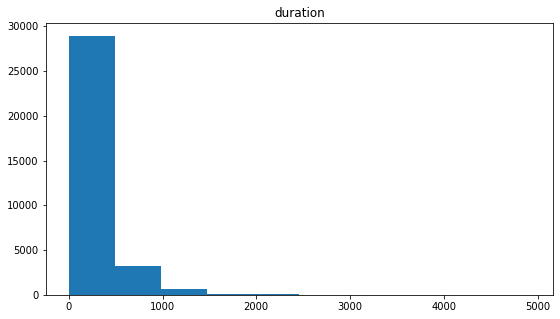

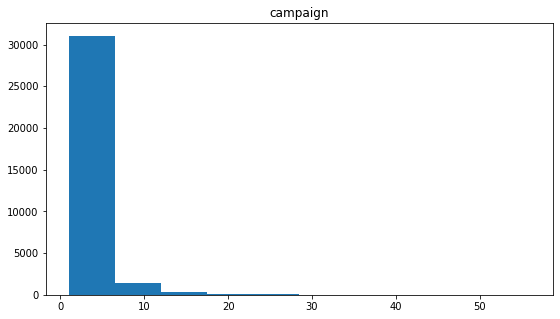

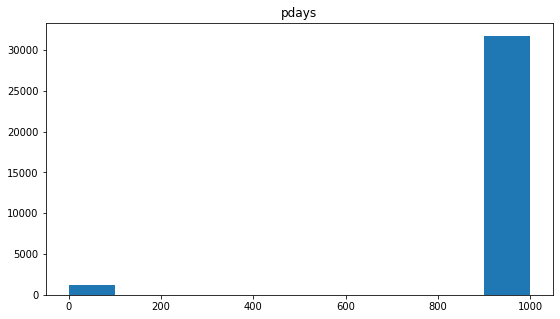

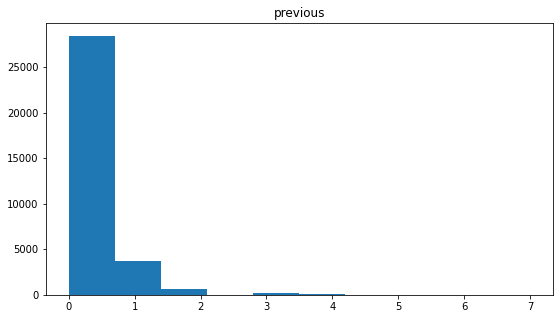

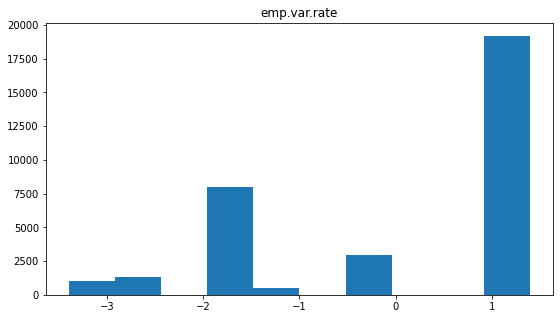

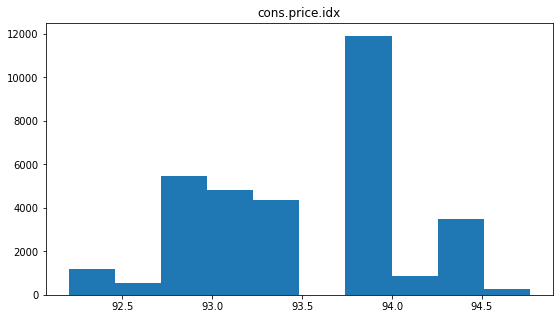

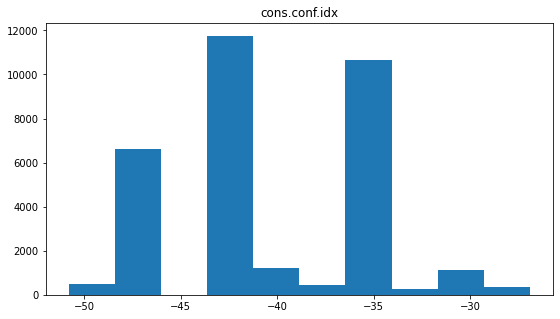

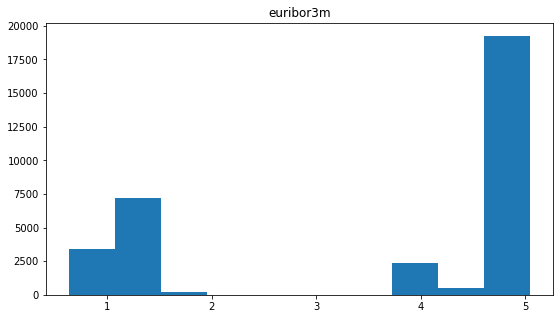

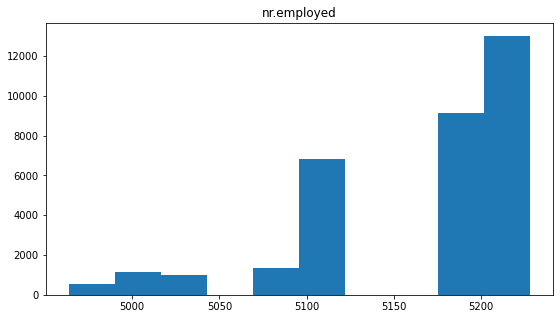

In [10]:
numeric_data = dataframe.select_dtypes(include=np.number) # select_dtypes selects data with numeric features
numeric_col = numeric_data.columns 
for column in numeric_col:
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.hist(dataframe[column])
    plt.title(column)

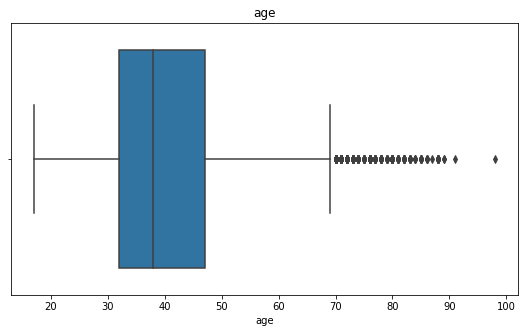

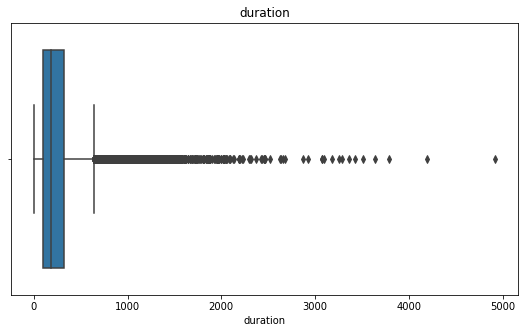

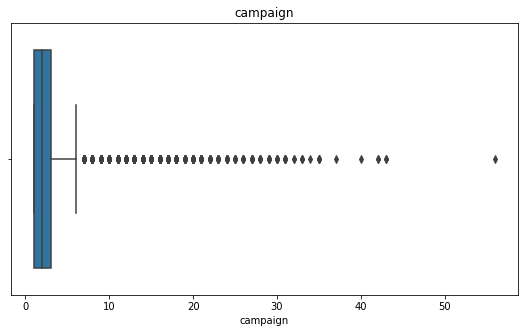

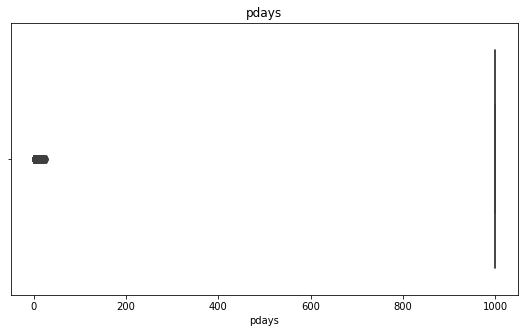

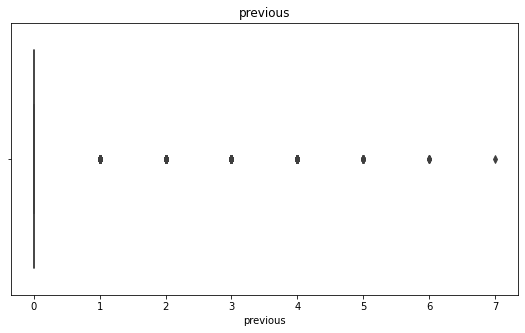

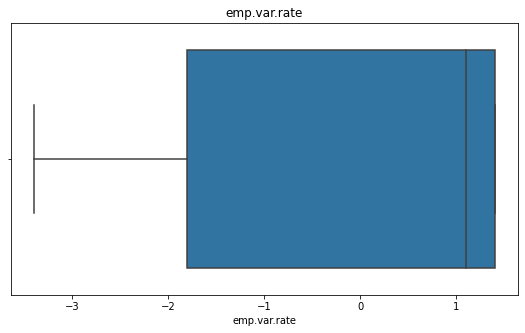

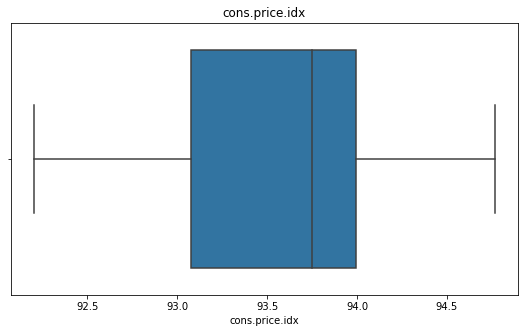

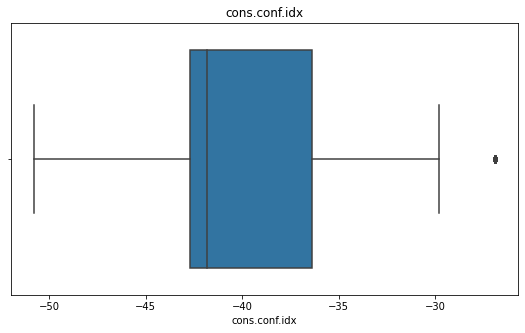

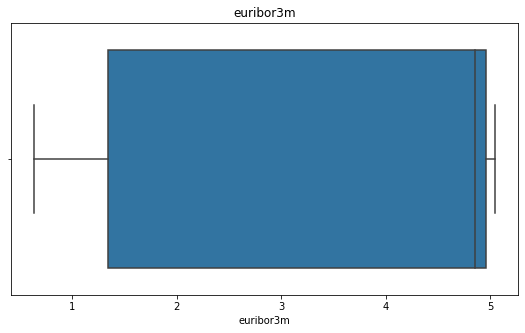

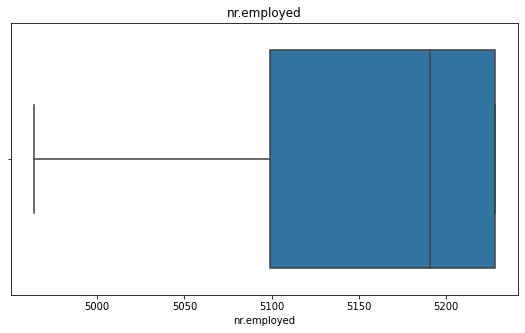

In [11]:
for column in numeric_col:
    plt.figure(figsize=(20,5))
    plt.subplot(122)
    sns.boxplot(dataframe[column])
    plt.title(column)

### Observation :

- As we can see from the histogram, the features `age`, `duration` and `campaign` are heavily skewed and this is due to the presence of outliers as seen in the boxplot for these features. We will deal with these outliers in the steps below.
- Looking at the plot for `pdays`, we can infer that majority of the customers were being contacted for the first time because as per the feature description for `pdays` the value 999 indicates that the customer had not been contacted previously. 
- Since the features `pdays` and `previous` consist majorly only of a single value, their variance is quite less and hence we can drop them since technically will be of no help in prediction.

### Dropping the columns `pdays` & `previous`

In [12]:
dataframe.drop(['pdays','previous'],1,inplace=True)

### Bivariate Analysis - Categorical Columns

Bivariate analysis involves checking the relationship between two variables simultaneously. In the code below, we plot every categorical feature against the target by plotting a barchart. 

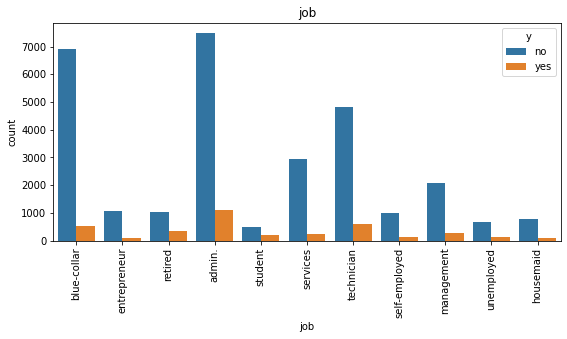

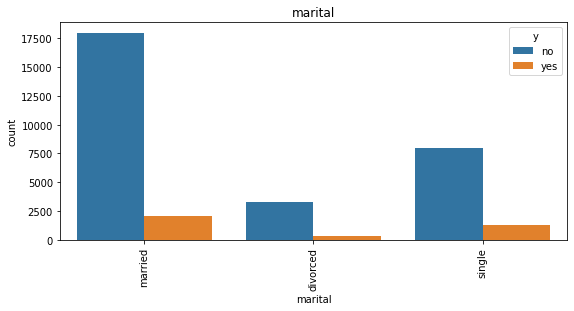

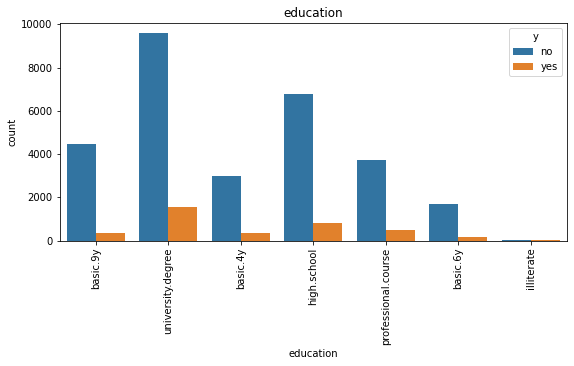

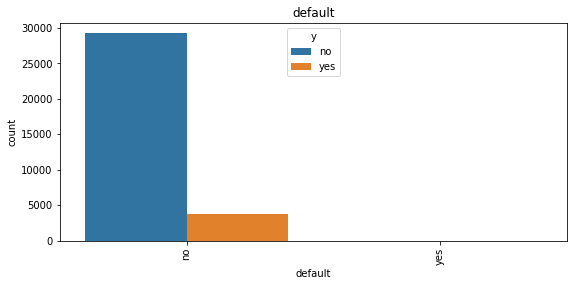

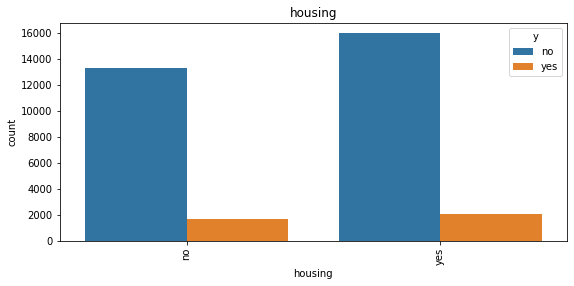

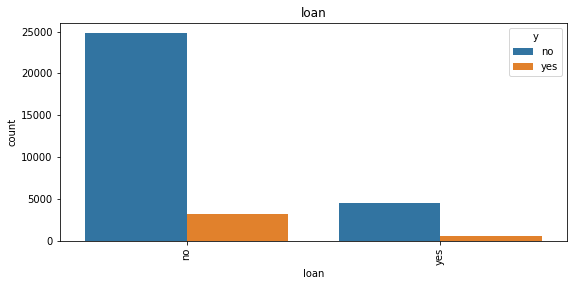

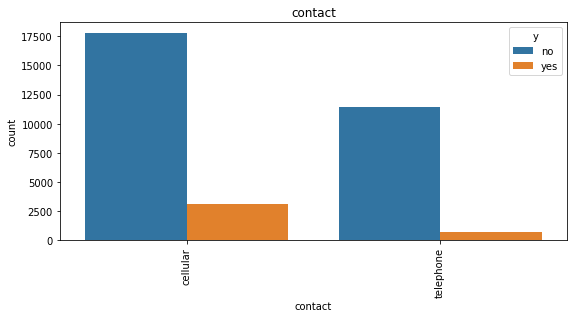

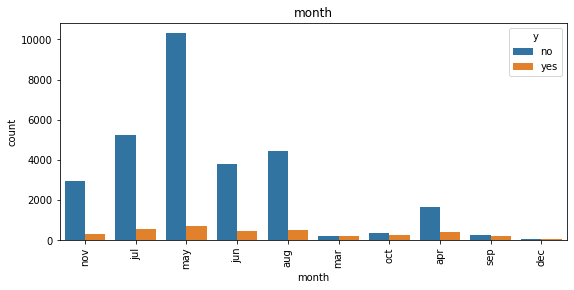

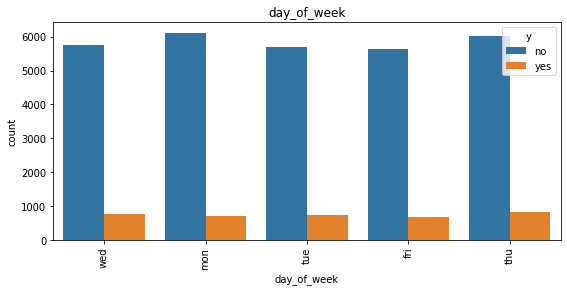

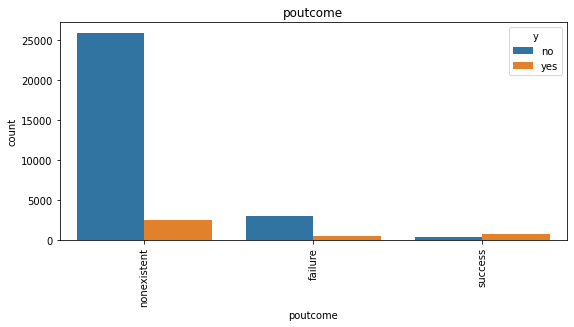

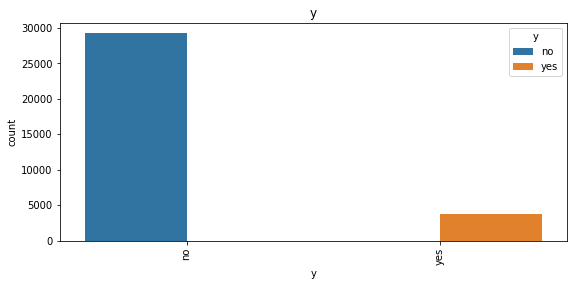

In [13]:


for column in categorical_col:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.countplot(x=dataframe[column],hue=dataframe['y'],data=dataframe)
    plt.title(column)    
    plt.xticks(rotation=90)

### Observations:

- The common traits seen for customers who have subscribed for the term deposit are :
    - Customers having administrative jobs form the majority amongst those who have subscirbed to the term deposit with technicians being the second majority.
    - They are married 
    - They hold a university degree
    - They do not hold a credit in default
    - Housing loan doesn't seem a priority to check for since an equal number of customers who have and have not subscribed to it seem to have subscribed to the term deposit.
    - Cell-phones should be the preferred mode of contact for contacting customers.

### Treating outliers in the continuous columns
 we use a method called **Winsorization**. In this method we define a confidence interval of let's say 90% and then replace all the outliers below the 5th percentile with the value at 5th percentile and all the values above 95th percentile with the value at the 95th percentile. 

In [14]:
numeric_col = dataframe.select_dtypes(include=np.number).columns

for col in numeric_col:    
    dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))



### Observation :

Using winsorization has resulted in removal of all the outliers from the numerical columns.  You can even use normalization or standardization for dealing with outliers. 

### Function to Label Encode Categorical variables



For the given dataset, we are going to label encode the categorical columns. 



In [16]:
# Initializing Label Encoder
le = LabelEncoder()

# Iterating through each of the categorical columns and label encoding them
for feature in categorical_col:
    try:
        dataframe[feature] = le.fit_transform(dataframe[feature])
    except:
        print('Error encoding '+feature)

#### PREPARING THE TRAIN AND TEST DATA


In [17]:
# Predictors
X = dataframe.iloc[:,:-1]

# Target
y = dataframe.iloc[:,-1]

# Dividing the data into train and test subsets
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)


#### FITTING THE MODEL AND PREDICTING THE VALUES

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5798
           1       0.60      0.34      0.43       792

    accuracy                           0.89      6590
   macro avg       0.75      0.65      0.69      6590
weighted avg       0.88      0.89      0.88      6590

ROC_AUC_SCORE is 0.6523204622980406


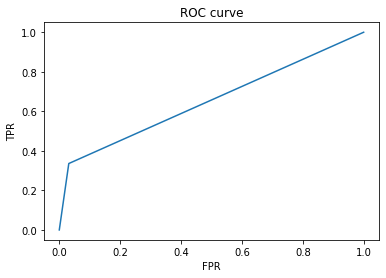

In [18]:
# run Logistic Regression model
model = LogisticRegression()
# fitting the model
model.fit(x_train, y_train)
# predicting the values
y_scores = model.predict(x_val)
# getting the auc roc curve
auc = roc_auc_score(y_val, y_scores)
print('Classification Report:')
print(classification_report(y_val,y_scores))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_scores)
print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_scores))
    
#fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()



[21:20:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5798
           1       0.62      0.51      0.56       792

    accuracy                           0.90      6590
   macro avg       0.78      0.73      0.75      6590
weighted avg       0.90      0.90      0.90      6590

ROC_AUC_SCORE is 0.7346400796512903


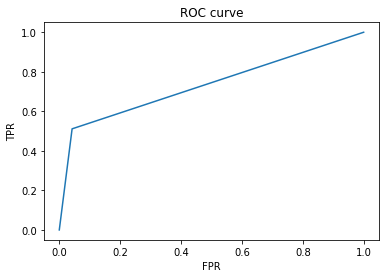

In [19]:
# Run XGBoost model
model = XGBClassifier()

model.fit(x_train, y_train)
y_scores = model.predict(x_val)
auc = roc_auc_score(y_val, y_scores)
print('Classification Report:')
print(classification_report(y_val,y_scores))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_scores)
print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_scores))
    
#fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Feature Selection 



# Grid-Search & Hyperparameter Tuning 

Hyperparameters are function attributes that we have to specify for an algorithm. By now, you should be knowing that grid search is done to find out the best set of hyperparameters for your model.  

### Using Grid Search for Logistic Regression

## Prediction on the test data

In the below task, we have performed a prediction on the test data. We have used Logistic Regression for this prediction. You can use the model of your choice that will give you the best metric score on the validation data. 

In this task below, we will read the test file and store the `Id` column from the test file in a variable `Id`. This column would be of use to us while submission since we need to have an Id column in the submission file which is the same Id of the observations in the test data.

We have to perform the same preprocessing operations on the test data that we have performed on the train data. For demonstration purposes, we have preprocessed the test data and this preprocessed data is present in the csv file `test_preprocessed.csv`

We then make a prediction on the preprocessed test data using the Grid Search Logisitic regression model. And as the final step, we concatenate this prediction with the `Id` column and then convert this into a csv file which becomes the `submission.csv` 

In [ ]:
# Actual Test File
test = pd.read_csv('../data/test.csv')

# Storing the Id column
Id = test[['Id']]

# Preprocessed Test File
test = pd.read_csv('../data/test_preprocessed.csv')
test.drop('Id',1,inplace=True)
test.head()